In [1]:
#importing libaries and initialising my network
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import plotly.graph_objects as go
#from plotly.colors import n_colorsy
import Deep_Neural_Network_Script
import mpmath

torch.cuda.empty_cache()

#device = torch.device("cpu")


#model
poly_model = Deep_Neural_Network_Script.NeuralNetwork(
    number_of_hidden_layers= 3, 
    number_of_auxillary_variable = 1, #n_features
    number_of_phase_space_parameters = 0, #n_features not involved in integration
    hidden_layer_size = 30,
    output_layer_size = 1,
    activation_function = "sigmoid",
    batch_size = 1,
    normalisation_coefficient = 120,
    xavier_gain = 1.5,
    device_used='cpu'
) 


#torch.set_printoptions(precision=20)

normalisation_coefficient = poly_model.normalisation_coefficient

#saved_model = '1L_GELU_10layer_30hidden_branch1_run9.pth'

0.6599120175960898
0.4743416490252569
0.6599120175960898


In [2]:
#Data to model
file_name_I1 = 'GlobalTemperatures.csv'
I1_data = pd.read_csv(file_name_I1)
Cummulative_days = I1_data['days ']
Mean_temp = I1_data['Land Average Temperature']
Mean_temp_uncertainty = I1_data['Temp uncertainty']

#normalise the data between 0 and 1
normalised_Mean_temp = torch.tensor(Mean_temp/(max(Mean_temp)-min(Mean_temp))).view(len(Mean_temp),1).to(poly_model.device_used)
normalised_Mean_temp_uncertainty = torch.tensor(Mean_temp_uncertainty/(max(Mean_temp)-min(Mean_temp))).view(len(Mean_temp),1).to(poly_model.device_used)
normalised_Cummulative_days = torch.tensor(Cummulative_days/max(Cummulative_days)).view(len(Mean_temp),1).to(poly_model.device_used)

#test set 

test_fraction = 0.7 #relative size of the test set
test_size = round(len(normalised_Cummulative_days)*0.7)
Temp_test = normalised_Mean_temp[:test_size]
Temp_uncertainty_test = normalised_Mean_temp_uncertainty[:test_size]
Days_test = normalised_Cummulative_days[:test_size]
Temp_val = normalised_Mean_temp[test_size:]
Temp_uncertainty_val = normalised_Mean_temp_uncertainty[test_size:]
Days_val = normalised_Cummulative_days[test_size:]



In [3]:

#training tools #investigate the MSLE
loss_function = nn.MSELoss()
optimizer = optim.Adam(poly_model.parameters(), lr =0.0001)#
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.99, patience = 60, verbose=True)# 0.75


network_gradients_array_hidden = []
network_gradients_array_input = []
network_gradients_array_output = []
network_gradients_array_hidden_std = []
network_gradients_array_input_std = []
network_gradients_array_output_std = []


iterations = 1000 
freq = 10
collection_rate = int(iterations/(freq))
i_indication = 0


#validation_set_size = 

#arrays to store information from the training
y_max_array = [] 
y_min_array = []
y_mean_array = []
y_std_array = []
loss_array = np.zeros(int(freq))
val_loss_array = np.zeros(int(freq))
iteration_array = np.zeros(int(freq))
lr_array = np.zeros(int(freq))

#make these np.zero arrays and fix values to them to increase speed
activation_value_array = [] #6 is because number of hidden layers + 2
activation_value_array_std = [] #6 is because number of hidden layers + 2
weight_array = []
bias_array = []

#training loop for regression using y_observed and y_predicted 
for epoch in range(iterations):

    if epoch == 10 or epoch ==int(iterations)-1:
        with torch.no_grad():
            network_gradients_array_hidden.append(poly_model.weights_hidden_hidden.grad)
            network_gradients_array_input.append(poly_model.weights_input_hidden.grad)
            network_gradients_array_output.append(poly_model.weights_hidden_output.grad)

   #zero gradients
    optimizer.zero_grad()   
      

    y_observed = Temp_test #from featurs off of Kaggle
   
    y_predicted = poly_model.forward(Days_test) #outputs from my network

    
    loss = loss_function(y_predicted, y_observed)
    
    loss.backward() #    #backward pass


    optimizer.step() #update parameters
    
    
    poly_model.eval() #
    with torch.no_grad():
        y_observed_val = Temp_val #from featurs off of Kaggle
   
        y_predicted_val = poly_model.forward(Days_val) #outputs from my network

        val_loss = loss_function(y_observed_val, y_predicted_val).to(torch.device(poly_model.device_used))
        #print(val_loss) 

   # scheduler.step(val_loss)
    
    
    poly_model.train()
   
    
    #figure out the collection rate for network performance params. 

    if (epoch + 1) % collection_rate == 0: #10000   
        
        poly_model.eval()
        with torch.no_grad():
            print(f'Epoch  [{epoch+1}/{iterations}],   Loss: {loss.item():.8f},   Val Loss: {val_loss.item():.8f}')
      #      print(f'network integrand: {outputs[0]}')
       #     print(f'true integrand: {y}')
            loss_array[i_indication] = loss
            val_loss_array[i_indication] = val_loss
            iteration_array[i_indication] = epoch + 1
            lr_array[i_indication] = optimizer.param_groups[0]['lr']
            i_indication = i_indication + 1
        poly_model.train()
   
  


Epoch  [100/1000],   Loss: 0.37157466,   Val Loss: 0.42693061
Epoch  [200/1000],   Loss: 0.09030036,   Val Loss: 0.10966379
Epoch  [300/1000],   Loss: 0.04791276,   Val Loss: 0.05135108
Epoch  [400/1000],   Loss: 0.04463881,   Val Loss: 0.04318314
Epoch  [500/1000],   Loss: 0.04451180,   Val Loss: 0.04202585
Epoch  [600/1000],   Loss: 0.04450906,   Val Loss: 0.04187084
Epoch  [700/1000],   Loss: 0.04450869,   Val Loss: 0.04185135
Epoch  [800/1000],   Loss: 0.04450831,   Val Loss: 0.04184498
Epoch  [900/1000],   Loss: 0.04450790,   Val Loss: 0.04183901
Epoch  [1000/1000],   Loss: 0.04450745,   Val Loss: 0.04183257


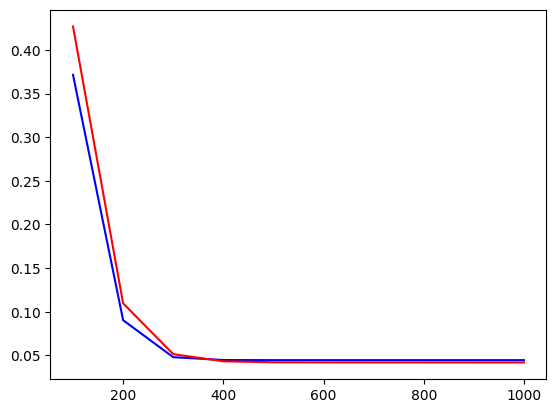

In [4]:
plt.plot(iteration_array, loss_array, 'blue')
plt.plot(iteration_array, val_loss_array, 'red')